In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CyclicLR
import torchvision.utils as vutils

from utils.loss import ContentLoss, AdversialLoss
from utils.transforms import get_default_transforms, get_no_aug_transform
from utils.datasets import get_dataloader
from utils.transforms import get_pair_transforms
from torch.utils.tensorboard import SummaryWriter
from models.discriminator import Discriminator
from models.generator import Generator

from datetime import datetime
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config
batch_size = 11
image_size = 224
learning_rate = 1.5e-4
beta1, beta2 = (.5, .99)
weight_decay = 1e-4
epochs = 100

# Models
netD = Discriminator().to(device)
netG = Generator().to(device)

netG.load_state_dict(torch.load("./checkpoints/init_netG.pth"))


optimizerD = AdamW(netD.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
optimizerG = AdamW(netG.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)

schedulerD = CyclicLR(optimizer=optimizerD, base_lr=learning_rate, max_lr=learning_rate*1e1, cycle_momentum=False)
schedulerG = CyclicLR(optimizer=optimizerG, base_lr=learning_rate, max_lr=learning_rate*1e1, cycle_momentum=False)

# Labels
cartoon_labels = torch.ones (batch_size, 1, image_size // 4, image_size // 4).to(device)
fake_labels    = torch.zeros(batch_size, 1, image_size // 4, image_size // 4).to(device)

# Loss functions
content_loss = ContentLoss(omega = 10, device = device)
adv_loss     = AdversialLoss(cartoon_labels, fake_labels)
BCE_loss     = nn.BCELoss().to(device)

# Dataloaders
torch.manual_seed(1)
real_dataloader    = get_dataloader("./datasets/real_images/flickr_31k", size = image_size, bs = batch_size)
cartoon_dataloader = get_dataloader("./datasets/cartoon_images_smoothed/Studio Ghibli", size = image_size, bs = batch_size, trfs=get_pair_transforms(image_size))

tracked_images = next(iter(real_dataloader)).to(device)
last_epoch = 0
last_i = 0

Save original tracked images for comparison.

In [4]:
original_images = tracked_images.detach().cpu()
grid = vutils.make_grid(original_images, padding=2, normalize=True, nrow=3)
plt.imsave(f"./results/original.png", np.transpose(grid, (1,2,0)).numpy())

Load previously trained networks.

In [5]:
netG.load_state_dict(torch.load("./checkpoints/_trained_netG.pth"))
netD.load_state_dict(torch.load("./checkpoints/_trained_netD.pth"))

<All keys matched successfully>

Load previous last epoch and iteration.

In [6]:
with open("./checkpoints/iter_data.pickle", "rb") as handle:
    last_epoch, last_i = pickle.load(handle)

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

start_epoch = last_epoch
start_i = last_i

print("Starting Training Loop...")
# For each epoch.
for epoch in range(start_epoch, epochs):
    # For each batch in the dataloader.
    
    real_dl_iter = iter(real_dataloader)
    cartoon_dl_iter = iter(cartoon_dataloader)
    iterations =  min(len(real_dl_iter), len(cartoon_dl_iter))
    
    for i in range(start_i, iterations):
        real_data = next(real_dl_iter)
        cartoon_data = next(cartoon_dl_iter)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
    
        netD.train()
        netG.eval()
        
        # Reset Discriminator gradient.
        netD.zero_grad()
        
        edge_data = cartoon_data[:, :, :, :image_size]
        cartoon_data = cartoon_data[:, :, :, image_size:]
        
        # Format batch.
        cartoon_data   = cartoon_data.to(device)
        edge_data      = edge_data.to(device)
        real_data      = real_data.to(device)

        # Generate image
        generated_data = netG(real_data)

        # Forward pass all batches through D.
        cartoon_pred   = netD(cartoon_data)      #.view(-1)
        edge_pred      = netD(edge_data)         #.view(-1)
        generated_pred = netD(generated_data)    #.view(-1)

        # Calculate discriminator loss on all batches.
        errD = adv_loss(cartoon_pred, generated_pred, edge_pred)

        # Calculate gradients for D in backward pass
        errD.backward()
        
        D_x = cartoon_pred.mean().item() # Should be close to 1

        # Update D
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        #netG.train()
        #netD.eval()

        # Reset Generator gradient.
        netG.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        generated_data = netG(real_data)
        generated_pred = netD(generated_data) #.view(-1)
        

        # Calculate G's loss based on this output
        errG = BCE_loss(generated_pred, cartoon_labels) + content_loss(generated_data, real_data)

        # Calculate gradients for G
        errG.backward()

        D_G_z2 = generated_pred.mean().item() # Should be close to 1

        # Update G
        optimizerG.step()

        # ---------------------------------------------------------------------------------------- #

        # Output training stats
        if i % 500 == 0:
            with torch.no_grad():
                fake = netG(tracked_images).detach().cpu()
                
            grid = vutils.make_grid(fake, padding=2, normalize=True, nrow=3)
            time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            plt.imsave(f"./results/E{epoch}_i{i}_{time}.png", np.transpose(grid, (1,2,0)).numpy())
            img_list.append(grid)
            
            print(('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f\t%s'
                % (epoch, epochs, i, iterations, errD.item(), errG.item(), D_x, D_G_z2, time)).expandtabs(25) )
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        schedulerD.step()
        schedulerG.step()
        
        last_i = i
    start_i = 0
    last_epoch = epoch

Save trained networks.

In [8]:
# Uncomment if you want to resume prevous traning.
#torch.save(netG.state_dict(), "./checkpoints/_trained_netG.pth")
#torch.save(netD.state_dict(), "./checkpoints/_trained_netD.pth")

Save last epoch and iteration.

In [9]:
with open("./checkpoints/iter_data.pickle", "wb") as handle:
    pickle.dump([last_epoch, last_i], handle)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture

fig = plt.figure(figsize=(24,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

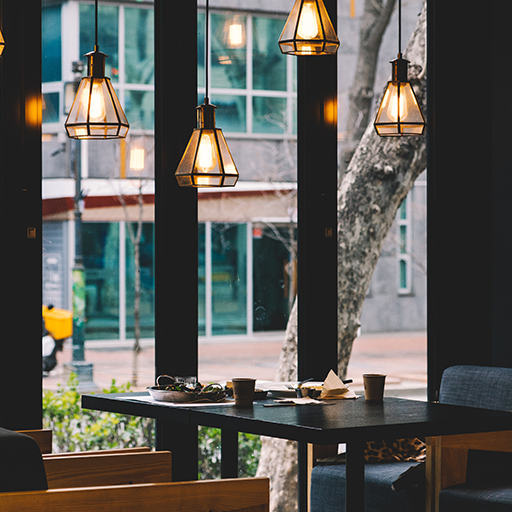

In [34]:
from PIL import Image
image = Image.open("4.png")
image

In [35]:
trf = get_no_aug_transform()
image = trf(image)
image = image.unsqueeze(0).to(device)
netG.eval()
with torch.no_grad():
    pred_image = netG(image)
netG.train()
print()

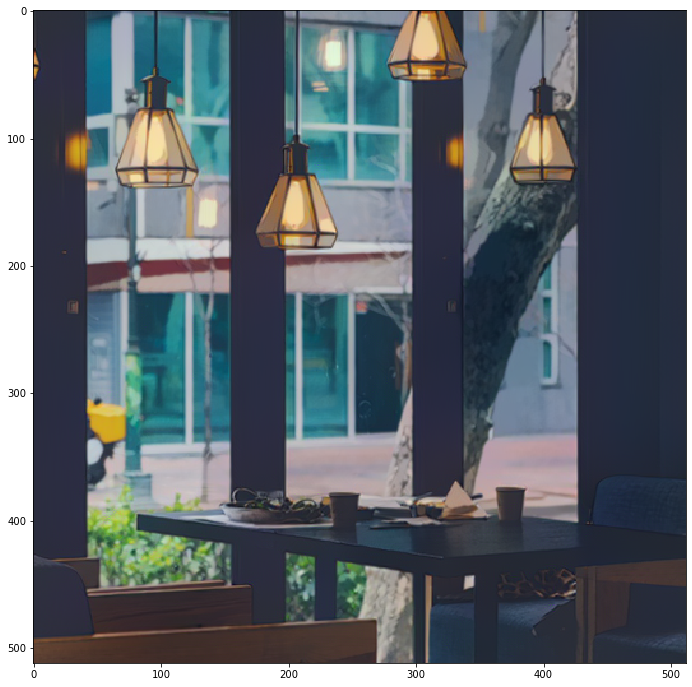

In [37]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(vutils.make_grid(pred_image.detach().cpu(), normalize=True).cpu(), (1, 2, 0)))

You can run the model on a folder of images using this function.

In [1]:
def test_image(path, file):
    image = Image.open(path + "/" + file).convert('RGB')
    name = file.split(".")[0]
    trf = get_no_aug_transform()
    image = trf(image)
    image = image.unsqueeze(0).to(device)
    netG.eval()
    with torch.no_grad():
        pred_image = netG(image)
    netG.train()

    img = np.transpose(vutils.make_grid(pred_image.detach().cpu(), normalize=True).cpu(), (1, 2, 0)).numpy()
    cv2.imwrite(f"./test_images/{name}.png", cv2.cvtColor(img*255, cv2.COLOR_RGB2BGR))

In [ ]:
os.listdir("foo")[0].split(".")[0]
for file in os.listdir("foo"):
    test_image("./foo/", file)